<a href="https://colab.research.google.com/github/AmbiTyga/73String/blob/main/73String-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing & Importing Packages

In [ ]:
!pip install scrapy -q

In [ ]:
import pandas as pd
import re
import json, operator
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Dataset Loading

In [ ]:
train = pd.read_excel('/content/Training_Data.01 (1).xlsx')
test = pd.read_excel('/content/Testing_Data_2_ (1).xlsx')

## Null Values in dataset

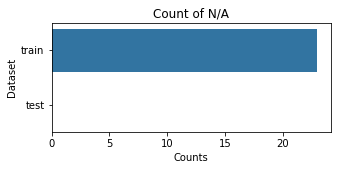

train:23
test:0


In [ ]:
plt.figure(figsize=(5,2))
ax = sns.barplot(y = ['train','test'],
         x = [train['Business Description'].isna().sum(),
              test['Business Description'].isna().sum()])
ax.set_xlabel('Counts')
ax.set_ylabel('Dataset')
ax.set_title('Count of N/A')
plt.show()
print(f"train:{train['Business Description'].isna().sum()}\ntest:{test['Business Description'].isna().sum()}")
# test['Business Description'].isna().sum()

## Filling N/A values

In [ ]:
#@title inc_info(keywords):
#@markdown - Googles keywords and scrapes the description from knowledge panel
#@markdown - Removes html tags and returns the description of the company as a string 
 
from w3lib.html import remove_tags
import requests
from scrapy.selector import Selector

def inc_info(keywords):
  '''
  The function googles the keywords, and returns the details from Knowledge Graph panel of Google. 
  '''
  keywords = keywords.replace(" ",'+')
  url = f'https://www.google.com/search?&q={keywords}'

  req = requests.get(url,
                   headers= {'User-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'})
  details_with_tags = Selector(text = req.text).css('span.hgKElc').get()

  if not details_with_tags:
    details_with_tags = Selector(text = req.text).css('div.kno-rdesc span').get()

  if details_with_tags:
    details = remove_tags(details_with_tags)
    return details

In [ ]:
train['Business Description'].fillna(train[train['Business Description'].isna()]['Company Name'].apply(inc_info),inplace = True)

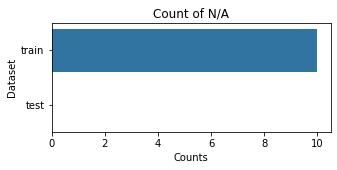

train:10
test:0


In [ ]:
plt.figure(figsize=(5,2))
ax = sns.barplot(y = ['train','test'],
         x = [train['Business Description'].isna().sum(),
              test['Business Description'].isna().sum()])
ax.set_xlabel('Counts')
ax.set_ylabel('Dataset')
ax.set_title('Count of N/A')
plt.show()
print(f"train:{train['Business Description'].isna().sum()}\ntest:{test['Business Description'].isna().sum()}")
# test['Business Description'].isna().sum()

> There are still 10 values unable to get, lets drop them

In [ ]:
train.dropna(inplace = True)

# Class Distribution

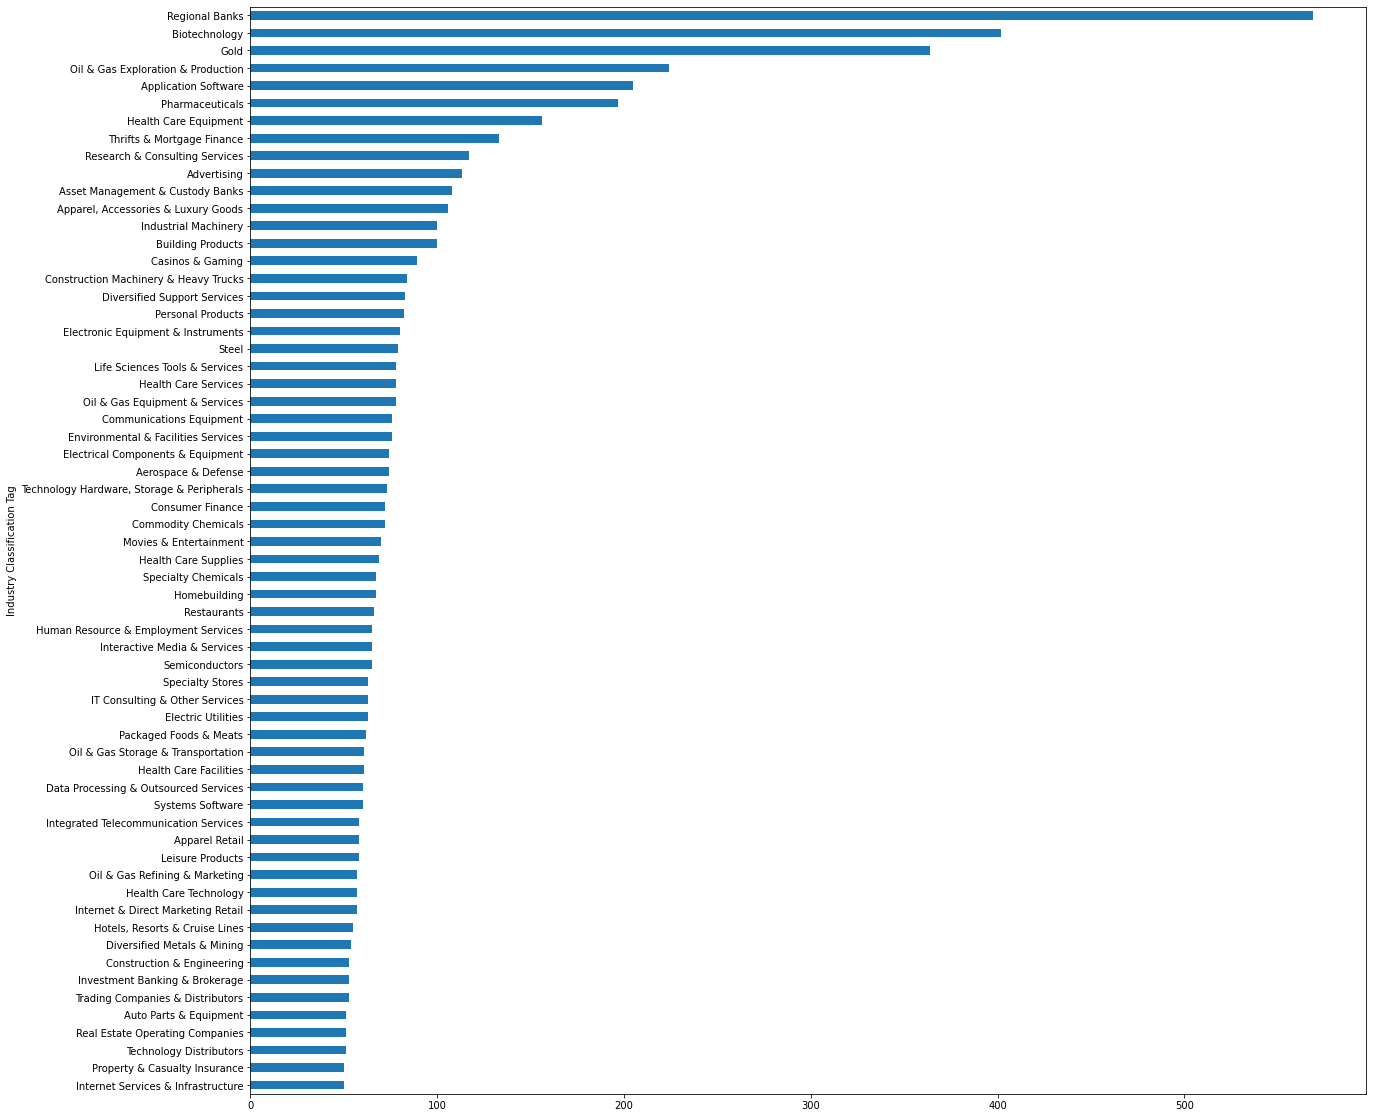

In [ ]:
train.groupby(['Industry Classification Tag'])['Company Name'].count().sort_values(ascending = True).plot.barh(figsize = (20,20))

# Description - Text

In [ ]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2021-02-13 04:33:16--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-02-13 04:33:16--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-02-13 04:33:17--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
#@title Load and Check Vocabulary of input
#@markdown - load_embed(filepath): returns embedding matrix
#@markdown - build_vocab(pd.Series): Returns a vocab from input
#@markdown - check_coverage(vocab, embedding_index): Compares text in dataset with text in embeddings 


## loads embedding vectors
def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
  
  if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
  else:
      embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
      
  return embeddings_index

def get_words(sentence):
  '''
  Removes unnecessary characters from the string
  sentence -> str
  get_words(...) -> str
  '''
  
  sentence = re.sub(r'(â€™s)',"'",sentence,flags = re.I)
  sentence = re.sub(r'Â',"",sentence,flags = re.I)
  sentence = re.sub(r'\%'," percent",sentence,flags = re.I)
  sentence = re.sub(r'\#',"Number ",sentence,flags = re.I)
  
  
  sentence = re.sub(r'-'," ",sentence,flags = re.I)
  sentence = re.sub('[,!?\'\:\(\)\/;]','',sentence)
  sentence = re.sub('\s+'," ",sentence)
  return sentence.split()

# Build vocab from dataset
def build_vocab(texts):
  '''
  Creates a vocabulary from the given corpus
  texts -> pandas Series object
  build_vocab(...) -> Dict()
  '''
  sentences = texts.apply(get_words).values
  vocab = {}
  for sentence in sentences:
      for word in sentence:
          try:
              vocab[word] += 1
          except KeyError:
              vocab[word] = 1
  return vocab

# Checks how many words present in embeddings wrt dataset
def check_coverage(vocab, embeddings_index):
  '''
  Checks the vocabulary from the given corpus with GLoVE data
  Returns out of vocabulary words from corpus that are not present in GLoVE data
  '''
  known_words = {}
  unknown_words = {}
  nb_known_words = 0
  nb_unknown_words = 0
  for word in vocab.keys():
      try:
          known_words[word] = embeddings_index[word]
          nb_known_words += vocab[word]
      except:
          unknown_words[word] = vocab[word]
          nb_unknown_words += vocab[word]
          pass

  print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
  print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
  unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
  unknown_words = pd.DataFrame(unknown_words,columns=['Word','Count'])
  return unknown_words

def ngrams_top(corpus,ngram_range,n=None,sw = False):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    if sw:
      vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    else:
      vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [ ]:
train['Company Name'] = train['Company Name'].apply(lambda x:" ".join(get_words(x)))
train['Business Description'] = train['Business Description'].apply(lambda x:" ".join(get_words(x)))

In [ ]:
!unzip /content/glove.840B.300d.zip
glove = load_embed("/content/glove.840B.300d.txt")

In [ ]:
vocab = build_vocab(train['Business Description'])
oov_glove = check_coverage(vocab, glove)

Found embeddings for 83.332% of vocab
Found embeddings for  98.560% of all text


In [ ]:
oov_glove.head(70)

,Word,Count
0,Biostem,12
1,Apyrum,12
2,Soil2O,12
3,HPIL,12
4,NoFire,11
5,Blockchain,11
6,iMetabolic,10
7,TOFUTTI,10
8,Hounde,10
9,ChromaID,10


## n-Grams

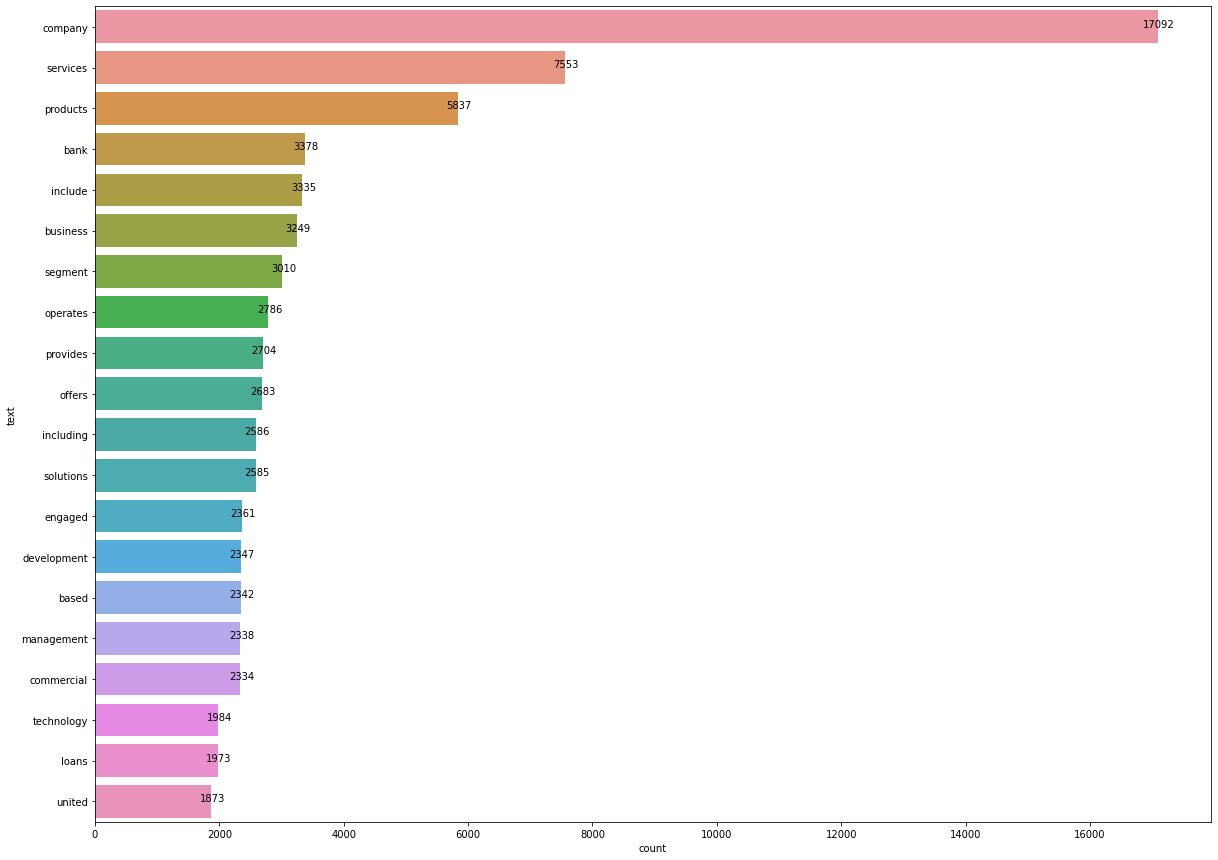

In [ ]:
# Unigrams
ngram2=ngrams_top(train['Business Description'],ngram_range=(1,1),sw=True).head(20)
plt.figure(figsize=(20,15))
ax = sns.barplot(x = ngram2['count'],
                 y = ngram2['text'])
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_x()+p.get_width()+20, p.get_y()+0.55), 
                   ha = 'center', va = 'center', 
                   xytext = (0,9), 
                   textcoords = 'offset points')
plt.show()

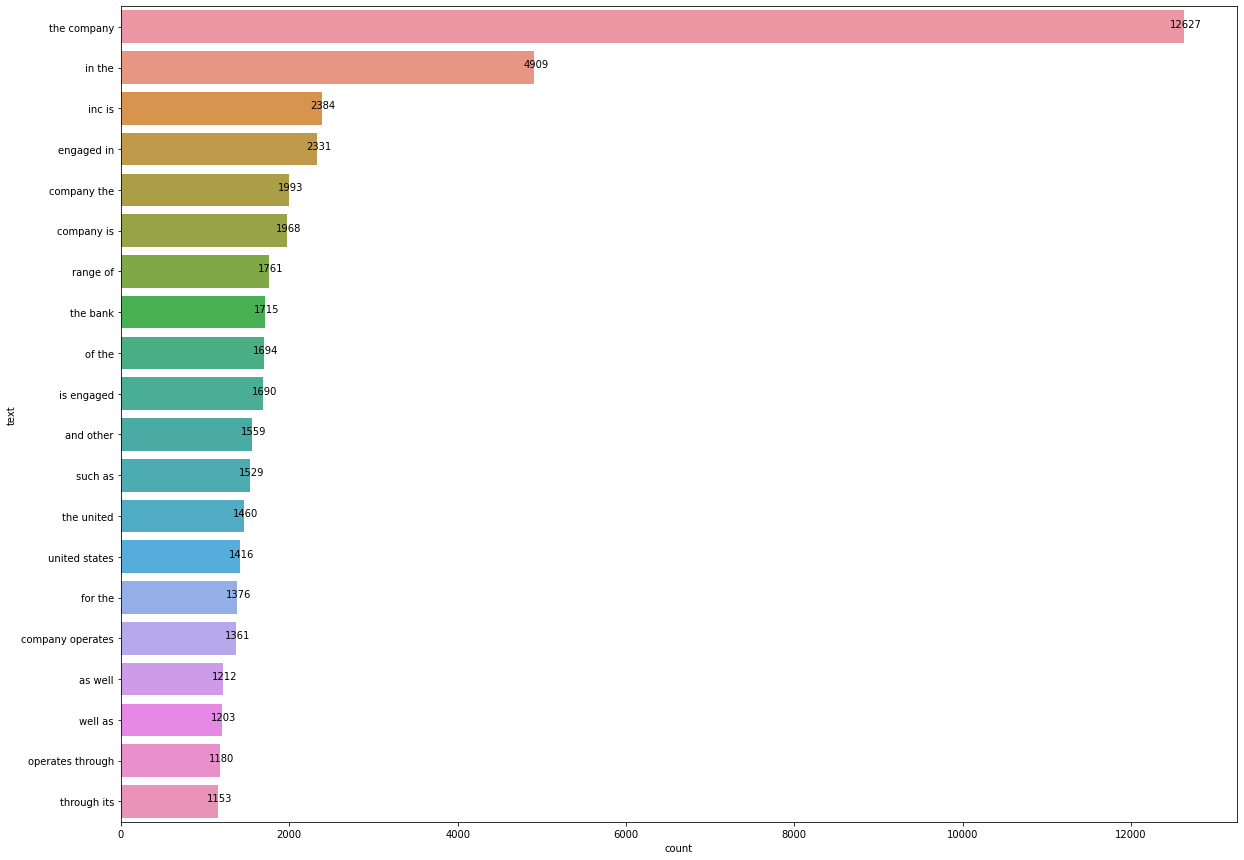

In [ ]:
# Bigrams
ngram2=ngrams_top(train['Business Description'],ngram_range=(2,2)).head(20)
plt.figure(figsize=(20,15))
ax = sns.barplot(x = ngram2['count'],
                 y = ngram2['text'])
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_x()+p.get_width()+20, p.get_y()+0.55), 
                   ha = 'center', va = 'center', 
                   xytext = (0,9), 
                   textcoords = 'offset points')
plt.show()

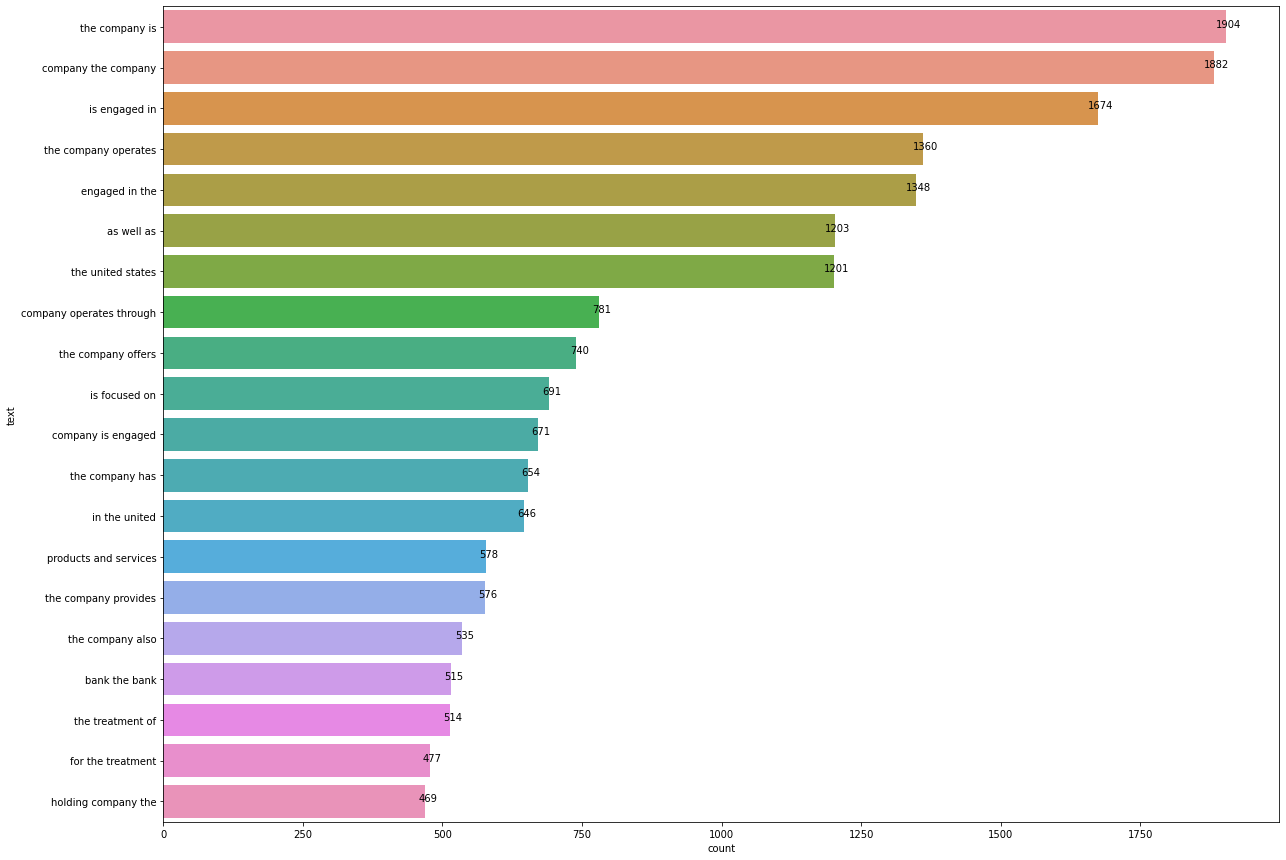

In [ ]:
# Trigrams
ngram3=ngrams_top(train['Business Description'],ngram_range=(3,3)).head(20)
plt.figure(figsize=(20,15))
ax = sns.barplot(x = ngram3['count'],
                 y = ngram3['text'])
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_x()+p.get_width()+5, p.get_y()+0.55), 
                   ha = 'center', va = 'center', 
                   xytext = (0,9), 
                   textcoords = 'offset points')
plt.show()

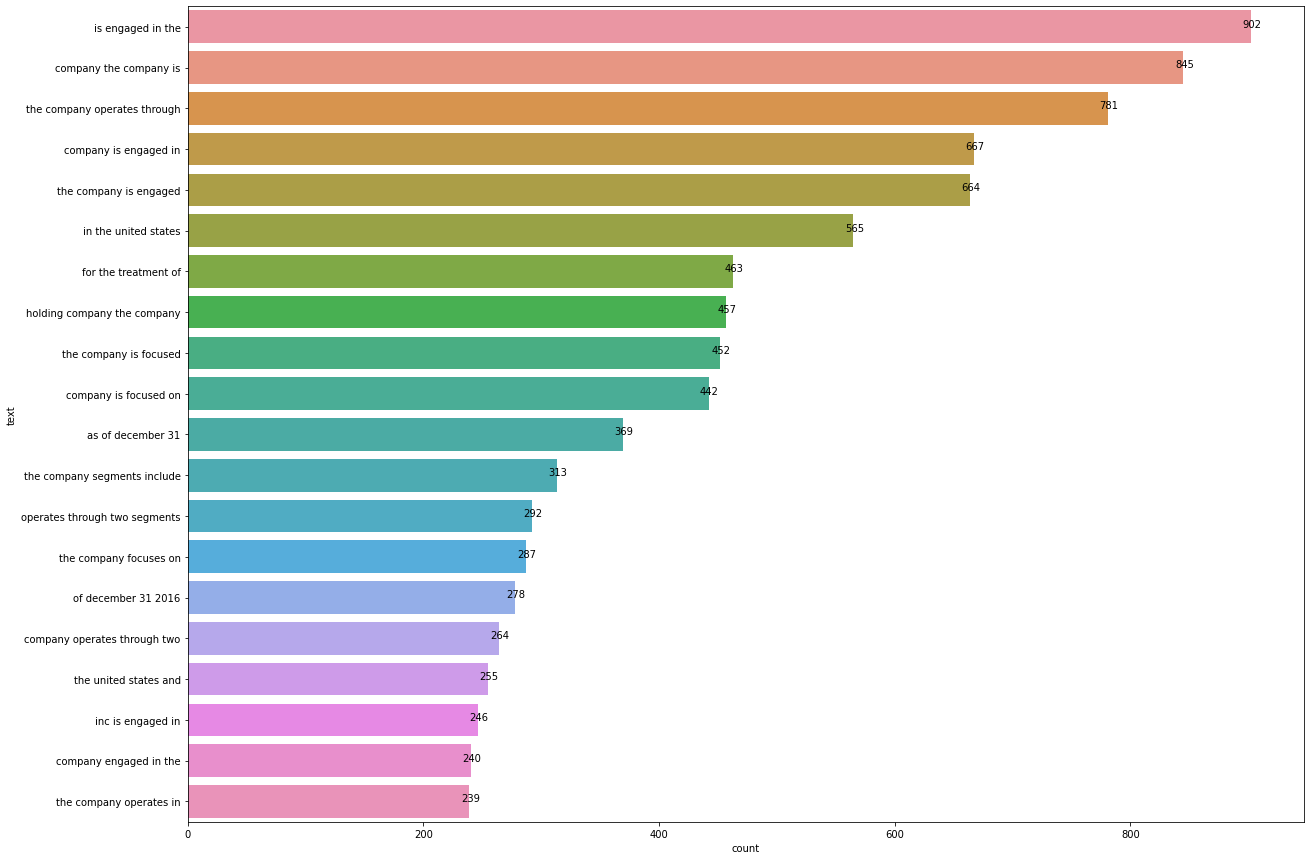

In [ ]:
# 4-grams
ngram4=ngrams_top(train['Business Description'],ngram_range=(4,4)).head(20)
plt.figure(figsize=(20,15))
ax = sns.barplot(x = ngram4['count'],
                 y = ngram4['text'])
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_x()+p.get_width()+0.8, p.get_y()+0.55), 
                   ha = 'center', va = 'center', 
                   xytext = (0,9), 
                   textcoords = 'offset points')
plt.show()

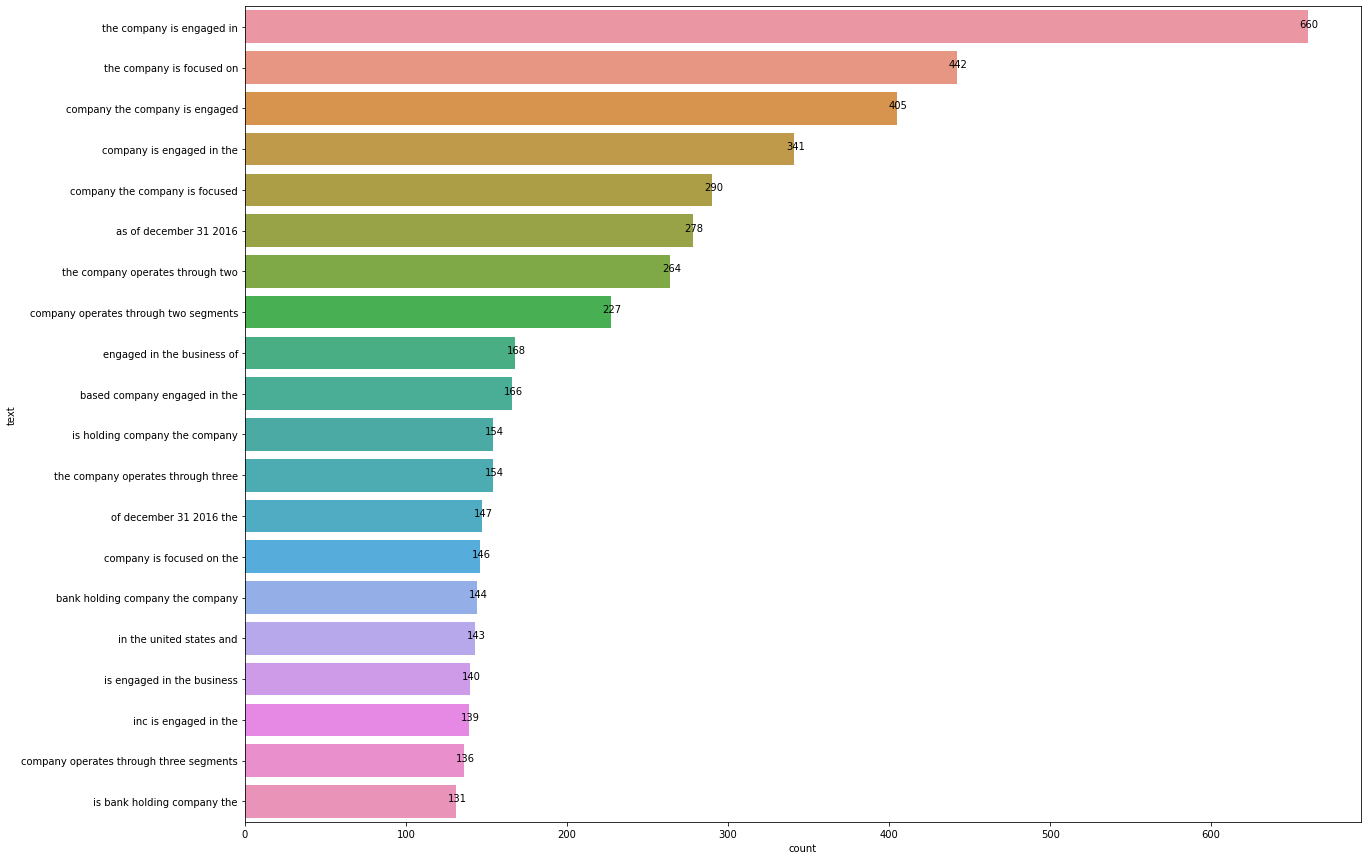

In [ ]:
# 5-grams
ngram5=ngrams_top(train['Business Description'],ngram_range=(5,5)).head(20)
plt.figure(figsize=(20,15))
ax = sns.barplot(x = ngram5['count'],
                 y = ngram5['text'])
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'), 
                   (p.get_x()+p.get_width()+0.8, p.get_y()+0.55), 
                   ha = 'center', va = 'center', 
                   xytext = (0,9), 
                   textcoords = 'offset points')
plt.show()

# Sentence and Text Length

In [ ]:
train['Business Description'] = train['Business Description'].apply(lambda x:re.sub('(Inc\.)','Incorporation',x,flags = re.I))
train['Business Description'] = train['Business Description'].apply(lambda x:re.sub('(corp\.)','corporation',x,flags = re.I))

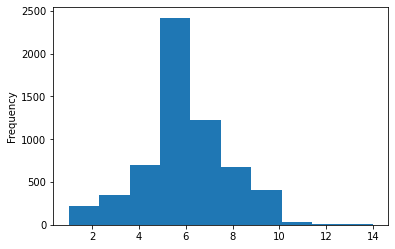

In [ ]:
train['sentence_count'] = train['Business Description'].str.split('\.[\s]+').apply(lambda x:len(x))
train['sentence_count'].plot.hist()

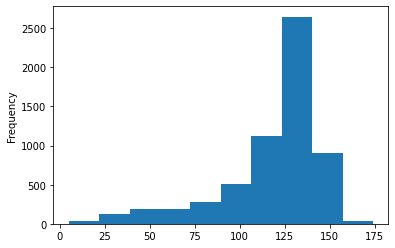

In [ ]:
train['words_count'] = train['Business Description'].str.split().apply(lambda x:len(x))
train['words_count'].plot.hist()

# WordCloud

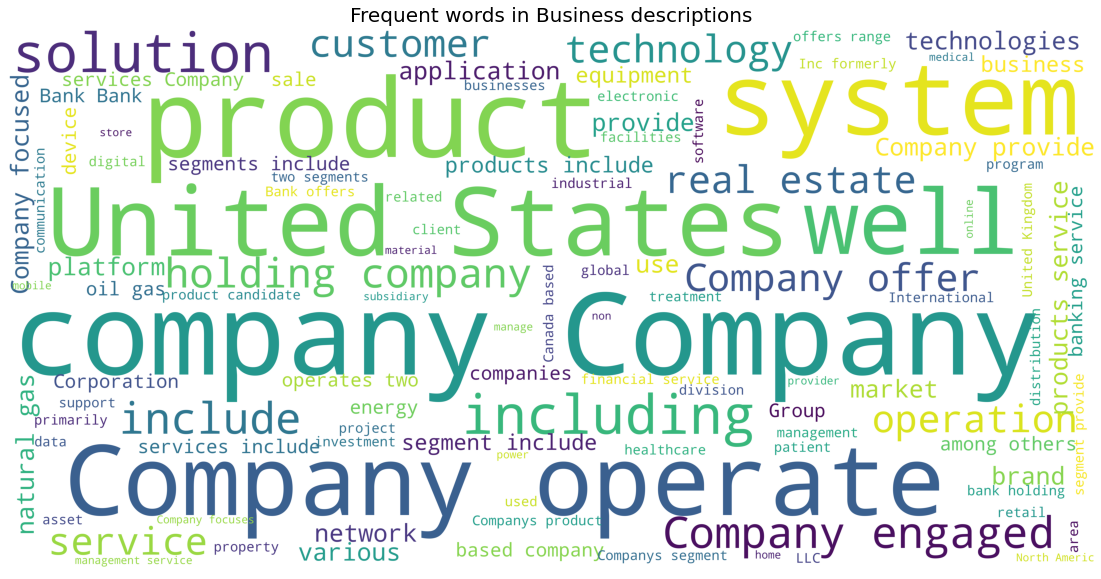

In [ ]:
texts = train['Business Description'].values
wc = WordCloud(max_words=2000, stopwords=STOPWORDS,scale = 20,mode = 'RGBA',background_color='white')
wc.generate(" ".join(texts))

plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Frequent words in Business descriptions", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()